In [25]:
import pandas as pd
import numpy as np
import os
from scipy.spatial.distance import euclidean
# from dtaidistance import dtw
# from fastdtw import fastdtw
from tslearn.metrics import dtw
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

/usr/local/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# 🧹 Data cleaning 

1. Give repeated words unique labels (the, the-2, the-3, etc)

In [3]:
def unique_word_labels(data):
    word_count = {}
    last_word = None
    unique_data = []

    for index, row in data.iterrows():
        word = row['word']
        
        # Check if this is a repeated word
        if word == last_word:
            # Use the same label as the previous occurrence if it's in a clump
            unique_word = unique_data[-1]['word']
        else:
            # If it's a new occurrence or a different word
            count = word_count.get(word, 0) + 1
            word_count[word] = count

            if count == 1:
                unique_word = word  # First occurrence remains the same
            else:
                unique_word = f"{word}-{count}"  # Label subsequent occurrences uniquely

        # Creating a new dictionary with modified word property
        new_item = row.to_dict()
        new_item['word'] = unique_word
        unique_data.append(new_item)

        last_word = word  # Update the last seen word
    return pd.DataFrame(unique_data)

2. Normalize pitches to a standard key

In [4]:
standard_key = 'C'

def half_steps_between(original_key, transpose_key):
    keys = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A"]
    original_key_index = keys.index(original_key)
    transpose_key_index = keys.index(transpose_key)
    return transpose_key_index - original_key_index

def transpose(original_hz, original_key, transpose_key, octave, id):
    steps_to_transpose = half_steps_between(original_key, transpose_key)
    new_frequency = original_hz * (2 ** (steps_to_transpose / 12))
    octave_shift = 0 if pd.isna(octave) else octave
    new_frequency *= (2 ** octave_shift)
    return new_frequency

def normalize_pitch(pitch_data, id, key, octave):
    normalized = []
    for index, row in pitch_data.iterrows():
        new_row = {col: row[col] for col in pitch_data.columns}
        new_row['frequency'] = transpose(row['frequency'], key, standard_key, octave, id)
        normalized.append(new_row)
    return pd.DataFrame(normalized)

3. Filter out frequencies < 100

In [5]:
def filter_frequencies(data):
    return data[data['frequency'] >= 100]

### Run this to clean all performances.

In [6]:
def get_data(id, key, octave):
    print(id, key)
    words = pd.DataFrame(pd.read_csv('words/' + id + '.csv'))
    pitch = pd.DataFrame(pd.read_csv('pitch/' + id + '.csv'))
    
    wordsCleaned = unique_word_labels(words)
    pitchCleaned = normalize_pitch(filter_frequencies(pitch), id, key, octave)
    
    return {
        'words_data': wordsCleaned,
        'pitch_data': pitchCleaned
    }

performances_raw = pd.DataFrame(pd.read_csv('performances.csv'))

performances = {row['id']: get_data(row['id'], row['key'], row['octave']) for index, row in performances_raw.iterrows()}

print(str(len(performances)) + ' performances cleaned and ready.')

michelle D
jazmine F
demi G#
carrie F#
harry G#
5 performances cleaned and ready.


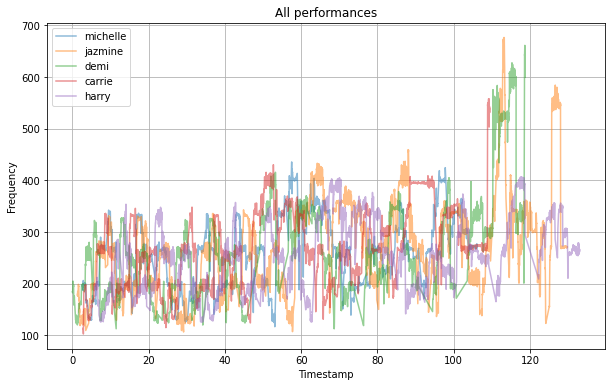

In [7]:
def plot_pitch(performances):
    plt.figure(figsize=(10, 6))

    for performer, data in performances.items():
        pitch_df = pd.DataFrame(data['pitch_data'])
        plt.plot(pitch_df['timestamp'], pitch_df['frequency'], label=performer, alpha=0.5)

    plt.title('All performances')
    plt.xlabel('Timestamp')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_pitch(performances)

# 🎤 DIVA 

## D = Density

Total notes in the performance compared to the standard performance.

In [8]:
def density(id):
    standard = performances['michelle']
    standard_length = len(standard['words_data'])
    length = len(performances[id]['words_data'])
    return ((length - standard_length) / standard_length)*100

In [35]:
# The top n by density
n = 3
density_dict = {performer: density(performer) for performer, data in performances.items()}
sorted_density = sorted(density_dict.items(), key=lambda x: x[1], reverse=True)[:n]
for performer, density_value in sorted_density:
    print(f"{performer}: {density_value}")

jazmine: 97.84172661870504
demi: 58.992805755395686
carrie: 41.007194244604314


## I = Interpretation

Comparing the pitch curve to the standard curve using DTW.

In [29]:
standard_performance = np.array(performances['michelle']['pitch_data']['frequency'].tolist())
dtw_differences = {}

for name, performance in performances.items():
    print(name)
    if name != 'michelle':
        current_performance = np.array(performance['pitch_data']['frequency'].tolist())
        distance = dtw(standard_performance, current_performance)
        dtw_differences[name] = distance
print('done')

michelle
jazmine
demi
carrie
harry
done


In [36]:
# Print top n DTW distances in descending order
n = 3
top_5 = sorted(dtw_differences.items(), key=lambda x: x[1], reverse=True)[:n]
for name, distance in top_5:
    print(f"{name}: {distance}")

jazmine: 5321.627768189828
demi: 5001.383439416785
carrie: 2900.211028984833


## V = Vibrato

Measuring how much vibrato they use.

I think we might want to cut this one

[(89.776, 90.08), (89.776, 90.085333333), (89.776, 90.090666667), (89.776, 90.096), (89.776, 90.101333333), (89.776, 90.106666667), (89.776, 90.112), (89.776, 90.117333333), (89.776, 90.122666667), (89.776, 90.128), (89.776, 90.133333333), (89.776, 90.138666667), (89.776, 90.144), (89.776, 90.149333333), (89.776, 90.154666667), (89.776, 90.16), (89.776, 90.165333333), (89.776, 90.170666667), (89.776, 90.176), (89.776, 90.181333333), (89.776, 90.186666667), (89.776, 90.192), (89.776, 90.197333333), (89.776, 90.202666667)]
Vibrato score for michelle: 150


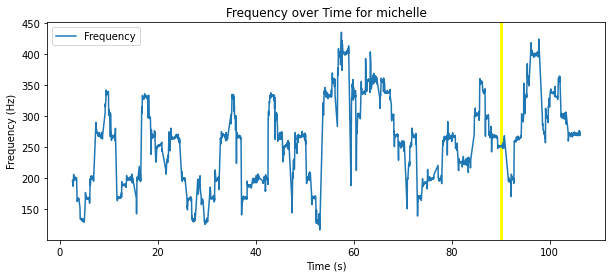

[(99.723900227, 100.025759637), (99.723900227, 100.031564626), (99.723900227, 100.037369615), (99.723900227, 100.043174603), (99.723900227, 100.048979592), (99.723900227, 100.05478458), (99.723900227, 100.060589569), (99.723900227, 100.066394558), (99.723900227, 100.072199546), (99.723900227, 100.078004535), (99.723900227, 100.083809524), (99.723900227, 100.089614512), (99.723900227, 100.095419501), (99.723900227, 100.10122449), (99.723900227, 100.107029478), (99.723900227, 100.112834467), (99.723900227, 100.118639456), (100.223129252, 100.524988662)]
Vibrato score for jazmine: 235


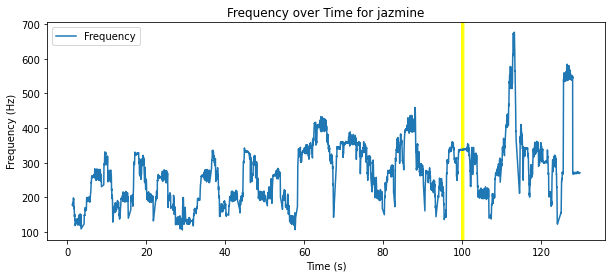

[]
Vibrato score for demi: 0


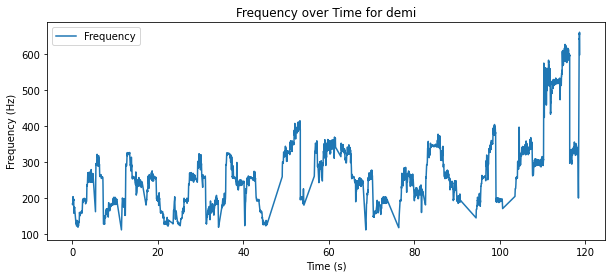

[(48.477460317, 48.779319728), (48.477460317, 48.785124717), (48.477460317, 48.790929705), (48.477460317, 48.796734694), (48.477460317, 48.802539683), (48.477460317, 48.808344671), (48.477460317, 48.81414966), (48.477460317, 48.819954649), (48.477460317, 48.825759637), (48.477460317, 48.831564626), (48.477460317, 48.837369615), (48.477460317, 48.843174603), (48.477460317, 48.848979592), (48.477460317, 48.85478458), (48.477460317, 48.860589569), (48.477460317, 48.866394558), (48.477460317, 48.872199546), (48.477460317, 48.878004535), (48.477460317, 48.883809524), (48.477460317, 48.889614512), (48.477460317, 48.895419501), (48.477460317, 48.90122449), (48.477460317, 48.907029478), (48.477460317, 48.912834467), (48.477460317, 48.918639456), (48.477460317, 48.924444444), (48.477460317, 48.930249433), (48.477460317, 48.936054422), (48.477460317, 48.94185941), (48.477460317, 48.947664399), (48.477460317, 48.953469388), (48.477460317, 48.959274376), (48.477460317, 48.965079365), (48.477460317

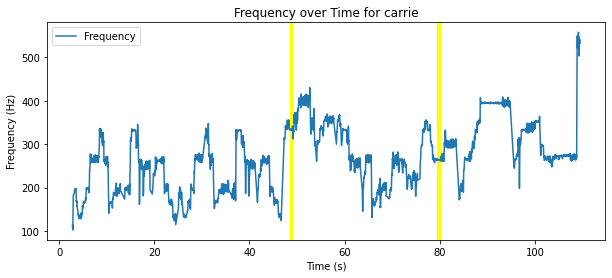

[(105.250249433, 105.552108844), (105.250249433, 105.557913832)]
Vibrato score for harry: 24


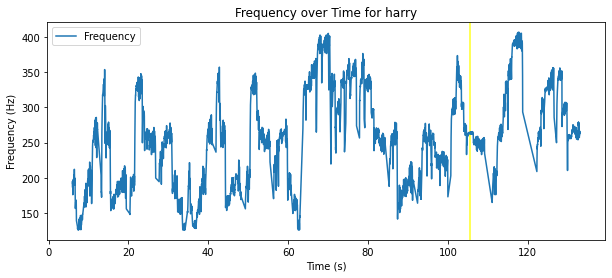

In [42]:
def detect_vibrato(pitch_data, min_duration=0.3, rate_threshold=5):
    """
    Detects vibrato in pitch data and returns the vibrato score and segments.

    :param pitch_data: DataFrame with 'timestamp' and 'frequency'.
    :param min_duration: Minimum duration (in seconds) to consider a note sustained.
    :param rate_threshold: Minimum rate of vibrato oscillations (in oscillations per second).
    :return: Vibrato score and list of vibrato segments (start and end times).
    """
    vibrato_score = 0
    vibrato_segments = []
    prev_freq = pitch_data['frequency'].iloc[0]
    start_time = pitch_data['timestamp'].iloc[0]

    for index, row in pitch_data.iterrows():
        freq_threshold = 0.07 * row['frequency']
        
        if abs(row['frequency'] - prev_freq) <= freq_threshold:
            duration = row['timestamp'] - start_time
            if duration >= min_duration:
                # Potential vibrato segment found
                segment = pitch_data[(pitch_data['timestamp'] >= start_time) & (pitch_data['timestamp'] <= row['timestamp'])]
                # Analyze for oscillation rate and depth
                oscillations = count_oscillations(segment, rate_threshold)
                vibrato_score += oscillations
                if oscillations > 0:
                    vibrato_segments.append((start_time, row['timestamp']))
        else:
            prev_freq = row['frequency']
            start_time = row['timestamp']

    return vibrato_score, vibrato_segments

def count_oscillations(segment, rate_threshold):
    frequencies = segment['frequency'].values
    timestamps = segment['timestamp'].values

    # Find peaks and troughs
    peaks = np.zeros(len(frequencies), dtype=bool)
    troughs = np.zeros(len(frequencies), dtype=bool)

    for i in range(1, len(frequencies) - 1):
        peaks[i] = frequencies[i] > frequencies[i - 1] and frequencies[i] > frequencies[i + 1]
        troughs[i] = frequencies[i] < frequencies[i - 1] and frequencies[i] < frequencies[i + 1]

    # Count cycles
    oscillation_count = 0
    in_cycle = False

    for i in range(1, len(frequencies) - 1):
        if (peaks[i] or troughs[i]) and not in_cycle:
            in_cycle = True
        elif in_cycle and (peaks[i] or troughs[i]):
            oscillation_count += 1
            in_cycle = False

    # Check rate of oscillations against the threshold
    duration = timestamps[-1] - timestamps[0]
    if duration > 0:
        rate = oscillation_count / duration
        if rate >= rate_threshold:
            return oscillation_count
    return 0


for name, performance in performances.items():
    vibrato_score, vibrato_segments = detect_vibrato(performance['pitch_data'])
    print(vibrato_segments)
    print(f"Vibrato score for {name}: {vibrato_score}")

    # Plotting the frequency over time
    plt.figure(figsize=(10, 4))
    plt.plot(performance['pitch_data']['timestamp'], performance['pitch_data']['frequency'], label='Frequency')
    
    # Highlight vibrato segments
    for start, end in vibrato_segments:
        plt.axvspan(start, end, color='yellow', alpha=0.3)

    plt.title(f"Frequency over Time for {name}")
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.legend()
    plt.show()

## A = Apex

What's their highest note?